<AxesSubplot: xlabel='timestamp', ylabel='count'>

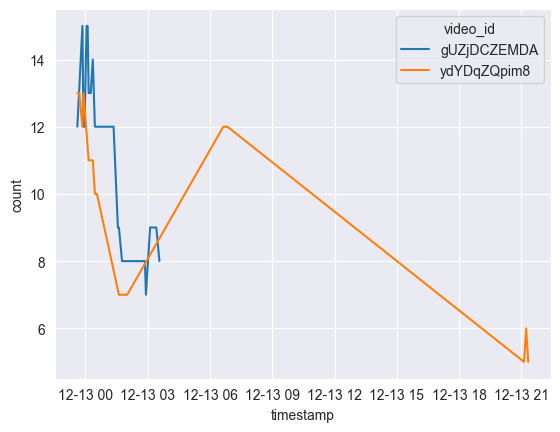

In [44]:
import seaborn as sns
from seaborn import FacetGrid
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create empty dict
file_dict = {}

# Get list of files in directory
files = os.listdir('data/images/cropped')

# Loop through the files
for file in files:
    # Split the filenames
    parts = file.split('_')
    if parts[0] == 'image':
        video_id = parts[1]
        timestamp = parts[2] + "_" + parts[3]
        # Create a key for the dictionary using the video_id and timestamp
        key = f"{video_id}_{timestamp}"
        # If the key doesn't exist in the dictionary, create a new list for it
        if key not in file_dict:
            file_dict[key] = []
        # Append the file path to the list of file paths for this key
        file_dict[key].append(os.path.join('data/images/cropped', file))
        
# Convert to Pandas dataframe
rows = []
for key, value in file_dict.items():
    video_id = key.split("_")[0]
    timestamp = key.split("_")[1] + "_" + key.split("_")[2]
    count = len(value)
    rows.append((video_id, timestamp, count))


df = pd.DataFrame(rows, columns=["video_id", "timestamp", "count"])
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d_%H-%M-%S')

# Group the data by video_id and timestamp, and calculate the count for each group
df_plot = df.groupby(['video_id', 'timestamp'])['count'].sum().reset_index()

# Use seaborn to create a timeseries plot with timestamp in the x-axis and count in the y-axis
sns.set_style("darkgrid")
sns.lineplot(x="timestamp", y="count", hue="video_id", data=df_plot)


In [28]:
df

,video_id,timestamp,count
0,gUZjDCZEMDA,2022-12-12 23:36:26,12
1,gUZjDCZEMDA,2022-12-12 23:51:12,15
2,gUZjDCZEMDA,2022-12-12 23:54:12,12
3,gUZjDCZEMDA,2022-12-12 23:57:12,12
4,gUZjDCZEMDA,2022-12-13 00:03:12,15
5,gUZjDCZEMDA,2022-12-13 00:06:12,15
6,gUZjDCZEMDA,2022-12-13 00:09:12,13
7,gUZjDCZEMDA,2022-12-13 00:15:12,13
8,gUZjDCZEMDA,2022-12-13 00:21:12,14
9,gUZjDCZEMDA,2022-12-13 00:27:13,12


In [17]:
import pyperclip
import json

# Create empty dict
file_dict = {}

# Get list of files in directory
files = os.listdir('data/images/cropped')

# Loop through the files
for file in files:
    # Split the filenames
    parts = file.split('_')
    if parts[0] == 'image':
        video_id = parts[1]
        timestamp = parts[2] + "_" + parts[3]
        # Create a key for the dictionary using the video_id and timestamp
        key = f"{video_id}_{timestamp}"
        # If the key doesn't exist in the dictionary, create a new list for it
        if key not in file_dict:
            file_dict[key] = []
        # Append the file path to the list of file paths for this key
        file_dict[key].append(os.path.join('data/images/cropped', file))

first_3_items = list(file_dict.items())[:3]
new_dict = dict(first_3_items)        
        
dict_str = json.dumps(new_dict)
pyperclip.copy(dict_str)

In [22]:
import pandas as pd

data = {
  "gUZjDCZEMDA_2022-12-12_23-36-26": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-36-26_86_0.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-36-26_86_1.jpg"],
  "gUZjDCZEMDA_2022-12-12_23-51-12": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-51-12_92_0.jpg"],
  "gUZjDCZEMDA_2022-12-12_23-54-12": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_0.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_1.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_10.jpg"]
}


# Create a list of tuples where each tuple consists of the video_id, timestamp, and count
rows = []
for key, value in data.items():
    video_id = key.split("_")[0]
    timestamp = key.split("_")[1] + "_" + key.split("_")[2]
    count = len(value)
    rows.append((video_id, timestamp, count))

# Create the dataframe from the list of tuples
df = pd.DataFrame(rows, columns=["video_id", "timestamp", "count"])

df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d_%H-%M-%S')
df.dtypes

# # Display the dataframe
# print(df)
# print(rows)
# print(df.dtypes)


video_id             object
timestamp    datetime64[ns]
count                 int64
dtype: object

In [18]:
data = {'video_id': ['gUZjDCZEMDA', 'ydYDqZQpim8', 'gUZjDCZEMDA'],
        'Date/Time': ['2022-12-12_23-36-26', '2022-12-12_23-36-26', '2022-12-12_23-36-26'],
        'count': [12, 13, 14]}
df = pd.DataFrame(data)

df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%Y-%m-%d_%H-%M-%S')
df.dtypes

video_id             object
Date/Time    datetime64[ns]
count                 int64
dtype: object

In [ ]:
import seaborn as sns
from seaborn import FacetGrid
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create empty dict
file_dict = {}

# Get list of files in directory
files = os.listdir('data/images/cropped')

# Loop through the files
for file in files:
    # Split the filenames
    parts = file.split('_')
    if parts[0] == 'image':
        video_id = parts[1]
        timestamp = parts[2] + "_" + parts[3]
        # Create a key for the dictionary using the video_id and timestamp
        key = f"{video_id}_{timestamp}"
        # If the key doesn't exist in the dictionary, create a new list for it
        if key not in file_dict:
            file_dict[key] = []
        # Append the file path to the list of file paths for this key
        file_dict[key].append(os.path.join('data/images/cropped', file))
        
# Convert to Pandas dataframe
rows = []
for key, value in file_dict.items():
    video_id = key.split("_")[0]
    timestamp = key.split("_")[1] + "_" + key.split("_")[2]
    count = len(value)
    rows.append((video_id, timestamp, count))


df = pd.DataFrame(rows, columns=["video_id", "timestamp", "count"])
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d_%H-%M-%S')


# Set the timestamp column as the index of the dataframe
df.set_index("timestamp", inplace=True)

# # Use seaborn to plot the timeseries
# sns.lineplot(data=df)
# sns.facet_wrap("video_id")
# plt.xticks(rotation=45)

g = FacetGrid(df, col="video_id")

# Use the FacetGrid object to plot a line plot of the timeseries data
g.map(sns.lineplot, "timestamp", "count")

# Rotate the x-axis tick labels to make them easier to read
g.set_xticklabels(rotation=45)


{"gUZjDCZEMDA_2022-12-12_23-36-26": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-36-26_86_0.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-36-26_86_1.jpg"], "gUZjDCZEMDA_2022-12-12_23-51-12": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-51-12_92_0.jpg"], "gUZjDCZEMDA_2022-12-12_23-54-12": ["data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_0.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_1.jpg", "data/images/cropped\\image_gUZjDCZEMDA_2022-12-12_23-54-12_93_10.jpg"]}